<a href="https://colab.research.google.com/github/oak-tree/2048/blob/master/rotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speed plots of difference between inner  out radius and center of sprayer

* **No** need to run code, but possible if you want,
* Diagram is interactive
* Edit from cursor


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


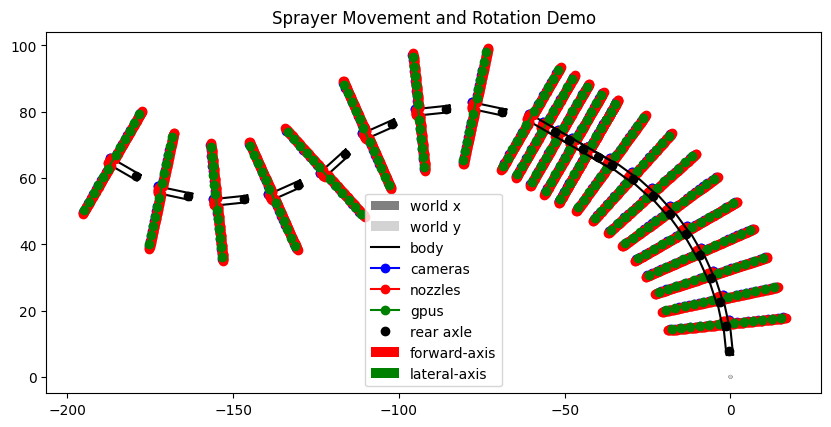

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

class Sprayer:
    def set_velocity(self, linear_velocity, angular_velocity):
        self.linear_velocity = linear_velocity  # meters per time unit
        self.angular_velocity = angular_velocity  # radians per time unit

    def go(self):
        self.is_moving = True

    def pause(self):
        self.is_moving = False

    def step(self, dt, radius=1.0):
        if getattr(self, 'is_moving', False):
            self.move_forward(self.linear_velocity * dt)
            self.rotate_by_angle_and_radius(self.angular_velocity * dt, radius)

    def replay(self, ax, spray_width=1.0, spray_length=0.2):
        for i, (pos, heading) in enumerate(self.path_history):
            self.origin = pos.copy()
            self.heading_rad = heading
            self.update_basis()
            self.render(ax, spray_width, spray_length, draw_legend=(i == 0))
            ax.text(self.origin[0], self.origin[1], str(i), fontsize=8, color='black', ha='center')
    def record(self):
        self.path_history.append((self.origin.copy(), self.heading_rad))

    def reset(self):
        self.origin = self._initial_origin.copy()
        self.heading_rad = self._initial_heading_rad
        self.update_basis()
        self.path_history = []
    def rotate_left(self, angle_rad, radius):
        self.rotate_by_angle_and_radius(angle_rad, radius)

    def rotate_right(self, angle_rad, radius):
        self.rotate_by_angle_and_radius(-angle_rad, -radius)
    def __repr__(self):
        return (f"Sprayer(origin={self.origin.tolist()}, heading={np.degrees(self.heading_rad):.1f}°, "
                f"rear_offset={self.rear_offset}, front_offset={self.front_offset}, "
                f"boom_offset={self.boom_offset}, center_boom_offset_y={self.center_boom_offset_y})")
    def __init__(self, origin, heading_rad, length, width, total_boom_length, num_cameras, num_nozzles, num_gpus=0, boom_offset=(0, 0), nozzle_y_offset=0, gpu_y_offset=0, center_boom_offset_y=0, rear_offset=0.0, front_offset=0.0):
        self.origin = np.array(origin, dtype=float)
        self._initial_origin = self.origin.copy()
        self._initial_heading_rad = heading_rad
        self.path_history = []
        self.heading_rad = heading_rad
        self.width = width
        self.total_boom_length = total_boom_length
        self.num_cameras = num_cameras
        self.num_nozzles = num_nozzles
        self.num_gpus = num_gpus
        self.boom_offset = boom_offset
        self.nozzle_y_offset = nozzle_y_offset
        self.gpu_y_offset = gpu_y_offset
        self.center_boom_offset_y = center_boom_offset_y
        self.rear_offset = rear_offset
        self.front_offset = front_offset
        self.update_basis()

        center_len = self.width
        side_len = (self.total_boom_length - center_len) / 2
        self.boom_lengths = {
            'left': side_len,
            'center': center_len,
            'right': side_len
        }

    def update_basis(self):
        cos_h = np.cos(self.heading_rad)
        sin_h = np.sin(self.heading_rad)
        self.basis_forward = np.array([cos_h, sin_h])
        self.basis_lateral = np.array([-sin_h, cos_h])

    def world_from_local(self, local_coords):
        lateral, forward = local_coords
        return self.origin + lateral * self.basis_lateral + forward * self.basis_forward

    def move_forward(self, distance):
        self.origin += distance * self.basis_forward

    def rotate_around_point_by_angle(self, xc, yc, angle_rad):
        center = np.array([xc, yc], dtype=float)
        rel_pos = self.origin - center
        c, s = np.cos(angle_rad), np.sin(angle_rad)
        rotation_matrix = np.array([[c, -s], [s, c]])
        self.origin = center + rotation_matrix @ rel_pos
        self.heading_rad += angle_rad
        self.update_basis()

    def rotate_by_angle_and_radius(self, angle_rad, R):
        center = self.origin + R * self.basis_lateral
        self.rotate_around_point_by_angle(center[0], center[1], angle_rad)

    def _compute_component_positions(self, total_count, forward_offset=0):
        boom_sections = ['left', 'center', 'right']
        lengths = [self.boom_lengths[sec] for sec in boom_sections]
        total_len = sum(lengths)

        margins = []
        counts = []

        for L in lengths:
            count = int(np.round(total_count * L / total_len))
            counts.append(count)
            margins.append(L / count / 2 if count > 0 else 0)

        discrepancy = total_count - sum(counts)
        counts[1] += discrepancy

        positions = []
        offset = -total_len / 2
        for section, length, count, margin in zip(boom_sections, lengths, counts, margins):
            if count > 0:
                step = (length - 2 * margin) / (count - 1) if count > 1 else 0
                for i in range(count):
                    lateral = offset + i * step + step / 2 if count > 1 else offset + length / 2
                    if self.boom_offset[1] < 0:
                        forward = self.rear_offset + self.boom_offset[1] + forward_offset
                    else:
                        forward = self.front_offset + self.boom_offset[1] + forward_offset
                    if section == 'center':
                        forward += self.center_boom_offset_y
                    boom_local = np.array([lateral, forward])
                    positions.append(self.world_from_local(boom_local))
            offset += length

        return positions

    def get_parts_world_coordinates(self):
        parts = {}
        parts['rear_axle'] = self.world_from_local(np.array([0, 0]))

        lateral_center = 0
        forward_start = self.rear_offset
        forward_end = self.front_offset
        corners_local = [
            [lateral_center - self.width / 2, forward_start],
            [lateral_center + self.width / 2, forward_start],
            [lateral_center + self.width / 2, forward_end],
            [lateral_center - self.width / 2, forward_end],
        ]
        parts['body'] = [self.world_from_local(np.array(p)) for p in corners_local]
        parts['cameras'] = self._compute_component_positions(self.num_cameras, forward_offset=0)
        parts['nozzles'] = self._compute_component_positions(self.num_nozzles, forward_offset=self.nozzle_y_offset)
        parts['gpus'] = self._compute_component_positions(self.num_gpus, forward_offset=self.gpu_y_offset)
        return parts

    def draw_basis(self, ax, scale=1.0):
        ax.quiver(*self.origin, *self.basis_forward * scale, color='r', angles='xy', scale_units='xy', scale=1, label='forward-axis')
        ax.quiver(*self.origin, *self.basis_lateral * scale, color='g', angles='xy', scale_units='xy', scale=1, label='lateral-axis')

    def render(self, ax, spray_width=1.0, spray_length=0.2, draw_legend=False):
        parts = self.get_parts_world_coordinates()

        # Draw world reference
        ax.quiver(0, 0, 1, 0, color='gray', scale_units='xy', angles='xy', scale=1, width=0.005, label='world x' if draw_legend else None)
        ax.quiver(0, 0, 0, 1, color='lightgray', scale_units='xy', angles='xy', scale=1, width=0.005, label='world y' if draw_legend else None)

        body = np.array(parts['body'] + [parts['body'][0]])
        ax.plot(body[:, 0], body[:, 1], 'k-', label='body' if draw_legend else None)

        for label, color in [('cameras', 'b'), ('nozzles', 'r'), ('gpus', 'g')]:
            positions = np.array(parts[label])
            ax.plot(positions[:, 0], positions[:, 1], f'{color}o-', label=label if draw_legend else None)

        for p in parts['nozzles']:
            ellipse = Ellipse(xy=p, width=spray_width, height=spray_length,
                              angle=np.degrees(self.heading_rad), color='blue', alpha=0.2)
            ax.add_patch(ellipse)

        ax.plot(*parts['rear_axle'], 'ko', label='rear axle' if draw_legend else None)
        self.draw_basis(ax, scale=self.width / 2) if draw_legend else None

if __name__ == '__main__':

    # Create sprayer instance
    sprayer = Sprayer(
        origin=(0, 0),
        heading_rad=np.pi/2,
        length=4.0,
        width=2.0,
        total_boom_length=36.0,
        num_cameras=24,
        num_nozzles=144,
        num_gpus=12,
        boom_offset=(0, 0.5),
        nozzle_y_offset=-0.25,
        gpu_y_offset=0.0,
        center_boom_offset_y=1.0,
        front_offset=8,
        rear_offset=-1
    )

    fig, ax = plt.subplots(figsize=(10, 10))

    # Set velocity and start motion
    sprayer.set_velocity(2.0, np.pi / 30)  # 2 m/s forward, 6°/s
    sprayer.go()

    # Simulate 10 time steps
    for _ in range(10):
        sprayer.step(1.0, radius=54)
        sprayer.record()
        sprayer.render(ax)

    sprayer.pause()

    sprayer.render(ax,draw_legend=True)

    # Drive forward 20 meters
    for _ in range(4):
        sprayer.move_forward(5)
        sprayer.record()
        sprayer.render(ax)

    # Rotate multiple times around 54-meter radius from origin
    for i in range(4):
        sprayer.rotate_left(np.pi / 10, 54)
        sprayer.record()  # ~18 degrees each time
        sprayer.render(ax)


    for i in range(4):
        sprayer.rotate_right(np.pi / 10, 54)
        sprayer.record()  # ~18 degrees each time
        sprayer.render(ax)
    ax.set_aspect('equal')
    ax.set_title('Sprayer Movement and Rotation Demo')

    ax.legend()




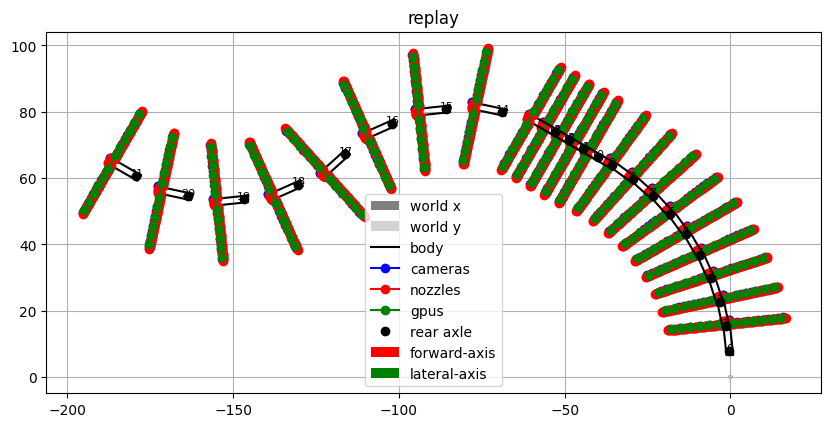

In [133]:
fig, ax = plt.subplots(figsize=(10, 10))

sprayer.replay(ax)
ax.set_aspect('equal')
ax.legend()

ax.set_title('replay')
plt.grid(True)
plt.show()

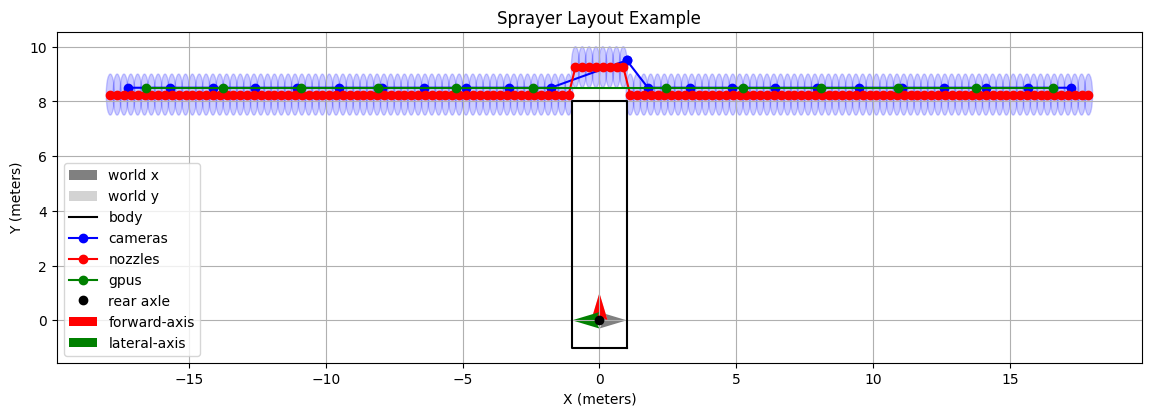

In [130]:
if __name__ == "__main__":
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title("Sprayer Layout Example")
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")

    # Instantiate the sprayer
    sprayer = Sprayer(
        origin=(0, 0),
        heading_rad=np.pi/2,
        length=4.0,
        width=2.0,
        total_boom_length=36.0,
        num_cameras=24,
        num_nozzles=144,
        num_gpus=12,
        boom_offset=(0, 0.5),
        nozzle_y_offset=-0.25,
        gpu_y_offset=0.0,
        center_boom_offset_y=1.0,
        front_offset=8,
        rear_offset=-1
    )

    # Render the sprayer and components
    sprayer.render(ax, spray_width=1.5, spray_length=0.3,draw_legend=True)

    ax.legend()
    plt.show()


In [1]:
import math
def mm_to_meter(mm):
    return mm/1000

def delta_x_exact(R_turn, c, N_kx, N_ky, H, R_gpu):
    print("R_turn: {}".format(R_turn))
    print("c: {}".format(c))
    print("N_kx: {}".format(N_kx))
    print("N_ky: {}".format(N_ky))
    print("H: {}".format(H))
    print("R_gpu: {}".format(R_gpu))
    x0 = R_turn + c + N_kx
    y0 = H + N_ky
    theta = 1 / R_gpu
    return x0 * (math.cos(theta) - 1) - y0 * math.sin(theta)

def delta_y_exact(R_turn, c, N_kx, N_ky, H, R_gpu):
    x0 = R_turn + c + N_kx
    y0 = H + N_ky
    theta = 1 / R_gpu
    return x0 * math.sin(theta) + y0 * (math.cos(theta) - 1) - 1

def delta_x_approx(R_turn, c, N_kx, N_ky, H, R_gpu):
    x0 = R_turn + c + N_kx
    y0 = H + N_ky
    return -x0 / (2 * R_gpu**2) - y0 / R_gpu

def delta_y_approx(R_turn, c, N_kx, N_ky, H, R_gpu):
    x0 = R_turn + c + N_kx
    y0 = H + N_ky
    return x0 / R_gpu - y0 / (2 * R_gpu**2) - 1

dx_e = delta_x_exact(3.0, 2.0, 1.0, 0.0, 2.0, 25.0)
dy_e = delta_y_exact(3.0, 2.0, 1.0, 0.0, 2.0, 25.0)
dx_a = delta_x_approx(3.0, 2.0, 1.0, 0.0, 2.0, 25.0)
dy_a = delta_y_approx(3.0, 2.0, 1.0, 0.0, 2.0, 25.0)




R_turn: 3.0
c: 2.0
N_kx: 1.0
N_ky: 0.0
H: 2.0
R_gpu: 25.0


In [16]:
JD_big_sprayer=  {

  # rotating with respect to 0,0
  "r_turn":48,

  # positive y, meaning front boom
  "boom_center": (0,mm_to_meter(4321)-mm_to_meter(6120.26)),

  # y distance between the cameras and the nozzles
  "nozzle_offset_y_from_camera":mm_to_meter(261.67),
  "frame_offset": 1-mm_to_meter(261.67),
  # relative to boom y-location
  # zero means camera and the boom are on the same line
  "camera_offset_y":0,

  "boom_length":mm_to_meter(18161)
}

# delta_x_exact(R_turn= JD_big_sprayer["r_turn"], c=camera_offset)


In [17]:
# Test rotation with a single point
test_point = Rotatable((1,0))
angles = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]

print("Testing rotation of point (1,0):")
for angle in angles:
    test_point = Rotatable((1,0))
    rotated = test_point.rotate(angle).value()
    print(f"Angle: {angle/np.pi}π")
    print(f"Position: {rotated}")
    print(f"Magnitude: {np.abs(rotated)}")
    print("---")

Testing rotation of point (1,0):
Angle: 0.0π
Position: (1+0j)
Magnitude: 1.0
---
Angle: 0.5π
Position: (6.123233995736766e-17+1j)
Magnitude: 1.0
---
Angle: 1.0π
Position: (-1+1.2246467991473532e-16j)
Magnitude: 1.0
---
Angle: 1.5π
Position: (-1.8369701987210297e-16-1j)
Magnitude: 1.0
---
Angle: 2.0π
Position: (1-2.4492935982947064e-16j)
Magnitude: 1.0
---


In [18]:
#@title The code, expand if you

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class Rotatable:
    def __init__(self,position):
        self.position = get_complex_np(position)

    def rotate(self,angle):
        self.position  =  self.position * np.exp(complex(1j*angle))
        return self

    def get_radius(self):
        return np.abs(self.position)

    def value(self):
         return self.position

def get_complex_np(position):
     if isinstance(position, np.ndarray) and np.issubdtype(position.dtype, np.complexfloating):
         return position
    #  print(position)
     if isinstance(position, complex):
        return np.array(position)

    #  if isinstance(position, np.ndarray):

     return np.array(complex(position[0],position[1]))
# Define a mock Sprayer class for demonstration purposes
class Sprayer:

    @classmethod
    def from_description(cls, description):
      # Get default values from __init__
      import inspect

      sig = inspect.signature(cls.__init__)
      defaults = {k: v.default for k, v in sig.parameters.items() if v.default is not inspect.Parameter.empty}

      return cls(
          left_boom=description["boom_length"],
          right_boom=description["boom_length"],
          sprayer_origin=(description["R1"], 0),
          boom_center=description.get("boom_center", defaults["boom_center"]),
          camera_offset_y=description.get("camera_offset_y", defaults["camera_offset_y"]),
          frame_distance=description.get("frame_distance", defaults["frame_distance"]),
          nozzle_offset_y=description.get("nozzle_offset_y_from_camera", defaults["nozzle_offset_y"]),
          number_of_cameras=description.get("number_of_cameras", defaults["number_of_cameras"]),
          number_of_nozzles=description.get("number_of_nozzles", defaults["number_of_nozzles"])
      )


    def __init__(self, left_boom, right_boom, sprayer_origin = (0,0), gps_position=(0,0),boom_center=(0,-3),number_of_cameras=24,camera_offset_y=0.3,frame_distance=1,number_of_nozzles=144,nozzle_offset_y=-0.25):


        self.left_boom = np.array(left_boom)
        self.right_boom =np.array(right_boom)
        self.gps_position = get_complex_np(gps_position)
        self.boom_center = get_complex_np(boom_center)
        self.number_of_nozzles = np.array(number_of_nozzles)
        self.nozzle_spacing = (right_boom+left_boom) / number_of_nozzles
        self.nozzle_offset_y= nozzle_offset_y
        self.camera_spacing = (right_boom+left_boom) / number_of_cameras
        self.camera_view= self.camera_spacing #= 1.5 # in meter1.5 # in meter
        self.number_of_cameras = np.array(number_of_cameras)
        # self.camera_position = get_complex_np(camera_position)
        self.camera_offset_y= camera_offset_y
        self.frame_offset = get_complex_np((0,frame_distance))

        self.sprayer_origin = get_complex_np(sprayer_origin)
        self.gpu_per_camera  = 2
    def get_nozzle_positions(self,i):
        i=i-self.number_of_nozzles/2
        return Rotatable(get_complex_np(self.sprayer_origin) + self.boom_center  +  get_complex_np((self.nozzle_spacing * (i+0.5),self.nozzle_offset_y)))

    def get_camera_position(self,i):

        return Rotatable(get_complex_np(self.sprayer_origin) + self.get_camera_relative_postion(i).value())

    def get_camera_relative_postion(self,i):
      '''
      return camera position relative to sprayer origin
      '''
      i=i-self.number_of_cameras/2
      return Rotatable(self.boom_center  +  get_complex_np((self.camera_spacing * (i+0.5),self.camera_offset_y)))
    # center of camera view
    def get_camera_center_acquired_location(self,i):
        return Rotatable(self.get_camera_position(i).value() + self.frame_offset)

    def get_camera_index_of_nozzle(self,i):
        return (i//(self.number_of_nozzles // self.number_of_cameras))


    def get_nozzle_positions_for_spraying_without_rotation(self,i):
        acquired_camera_postion = self.get_camera_center_acquired_location(self.get_camera_index_of_nozzle(i)).value()
        if self.sprayer_origin.imag != 0:
            print("sprayer_origin is not  alignement with x-axis, need to rotate positions")
            return None
        nozzle_position = self.get_nozzle_positions(i).value()
         # use acquired camera position as reference for y axis if sprayerorigin is align with x-axis and y-axis is 0
        return Rotatable((nozzle_position.real,acquired_camera_postion.imag))


    def get_camera_view_left_right(self,i):
        return Rotatable(self.get_camera_center_acquired_location(i).value() + get_complex_np((-self.camera_view/2,0))),Rotatable(self.get_camera_center_acquired_location(i).value() + get_complex_np((self.camera_view/2,0)))

    def get_camera_radius(self,i):
        return self.get_camera_position(i).get_radius()

    def get_gpu_index_by_camera(self,i):

        return (i//self.gpu_per_camera)

    def get_gpu_position_by_camera(self,i):
        return self.get_gpu_position(self.get_gpu_index_by_camera(i))

    def get_gpu_position(self,i):
        position = self.get_camera_position(i*self.gpu_per_camera).value() + self.get_camera_position(i*self.gpu_per_camera +1 ).value()
        print(i)
        print("center camera pos {}".format(position))
        return Rotatable(position/2)

    def get_gpu_radius(self,i):
        return self.get_gpu_position(i).get_radius()

    def get_camera_acquired_radius(self,i):
        return self.get_camera_center_acquired_location(i).get_radius()

    def get_sprayer_position(self):
        return Rotatable(get_complex_np(self.sprayer_origin))

    def get_sprayer_origin(self):
        return Rotatable(get_complex_np(self.sprayer_origin))
    def calculate_speed_at_position(self, turn_radius, gps_speed, position):
        # Mock calculation for demonstration
        return gps_speed * (turn_radius + position) / turn_radius

    def get_sprayer_radius(self):
        return self.get_sprayer_position().get_radius()

    def __str__(self):
        return (f"Sprayer:\n"
                f"  Left Boom Length: {self.left_boom} m\n"
                f"  Right Boom Length: {self.right_boom} m\n"
                f"  GPS Position: {self.gps_position} (complex)\n"
                f"  Boom Center: {self.boom_center} (complex)\n"
                f"  Number of Nozzles: {self.number_of_nozzles}\n"
                f"  Nozzle Spacing: {self.nozzle_spacing:.3f} m\n"
                f"  Nozzle Offset Y: {self.nozzle_offset_y} m\n"
                f"  Number of Cameras: {self.number_of_cameras}\n"
                f"  Camera Spacing: {self.camera_spacing:.3f} m\n"
                f"  Camera View Width: {self.camera_view} m\n"
                f"  Camera Offset Y: {self.camera_offset_y} m\n"
                f"  Frame Offset: {self.frame_offset} (complex)\n"
                f"  Sprayer Origin: {self.sprayer_origin} (complex)")

    def __repr__(self):
        return self.__str__()



In [19]:
# print(complex(1,0))
print(Rotatable((1,1)).rotate(np.pi/2).value())
print(Sprayer(18,18).get_nozzle_positions(10).value())
print(Sprayer(18,18).get_nozzle_positions(10).rotate(np.pi/2).value())
print(Sprayer(18,18).get_nozzle_positions(10).rotate(np.pi/2).value().real)
print(Sprayer(18,18).get_nozzle_positions(10).rotate(np.pi/2).value().imag)
print(Sprayer(18,18).get_nozzle_positions(10).rotate(np.pi/2).get_radius())
R=30
print(Sprayer(18,18,sprayer_origin=(R,0)).get_nozzle_positions(10).rotate(np.pi/2).get_radius())
i=1
for j in range(1,10):
    print(Sprayer(18,18,sprayer_origin=(R,0)).get_nozzle_positions(i).rotate(np.pi/j).get_radius())

for j in range(1,10):
    print(Sprayer(18,18,sprayer_origin=(R,0)).get_sprayer_position().rotate(np.pi/j).get_radius())

for j in range(1,10):
    print(Sprayer(18,18,sprayer_origin=(R,0)).get_camera_position(i).rotate(np.pi/j).get_radius())

for j in range(1,10):
    print(Sprayer(18,18,sprayer_origin=(R,0)).get_camera_center_acquired_location(i).rotate(np.pi/j).get_radius())


(-0.9999999999999999+1j)
(-15.375-3.25j)
(3.249999999999999-15.375j)
3.249999999999999
-15.375
15.7147422823284
14.981759743100943
12.794652203166759
12.794652203166759
12.794652203166759
12.794652203166757
12.794652203166759
12.794652203166759
12.794652203166759
12.794652203166759
12.79465220316676
30.0
30.0
30.0
30.0
30.0
30.0
30.000000000000004
30.000000000000004
29.999999999999996
14.503534052085376
14.503534052085376
14.503534052085376
14.503534052085374
14.503534052085374
14.503534052085374
14.503534052085376
14.503534052085376
14.503534052085374
14.3510452580988
14.3510452580988
14.351045258098797
14.351045258098797
14.351045258098798
14.351045258098798
14.3510452580988
14.351045258098797
14.3510452580988


0
center camera pos (-13.333333333333336-5.4j)
0
center camera pos (-13.333333333333336-5.4j)
1
center camera pos (-3.552713678800501e-15-5.4j)
1
center camera pos (-3.552713678800501e-15-5.4j)
2
center camera pos (13.333333333333332-5.4j)
2
center camera pos (13.333333333333332-5.4j)
3
center camera pos (26.666666666666664-5.4j)
3
center camera pos (26.666666666666664-5.4j)
4
center camera pos (40-5.4j)
4
center camera pos (40-5.4j)
5
center camera pos (53.33333333333333-5.4j)
5
center camera pos (53.33333333333333-5.4j)
6
center camera pos (66.66666666666667-5.4j)
6
center camera pos (66.66666666666667-5.4j)
7
center camera pos (80-5.4j)
7
center camera pos (80-5.4j)
8
center camera pos (93.33333333333334-5.4j)
8
center camera pos (93.33333333333334-5.4j)
9
center camera pos (106.66666666666667-5.4j)
9
center camera pos (106.66666666666667-5.4j)
10
center camera pos (120-5.4j)
10
center camera pos (120-5.4j)
11
center camera pos (133.33333333333334-5.4j)
11
center camera pos (133.333

<Figure size 1200x800 with 0 Axes>

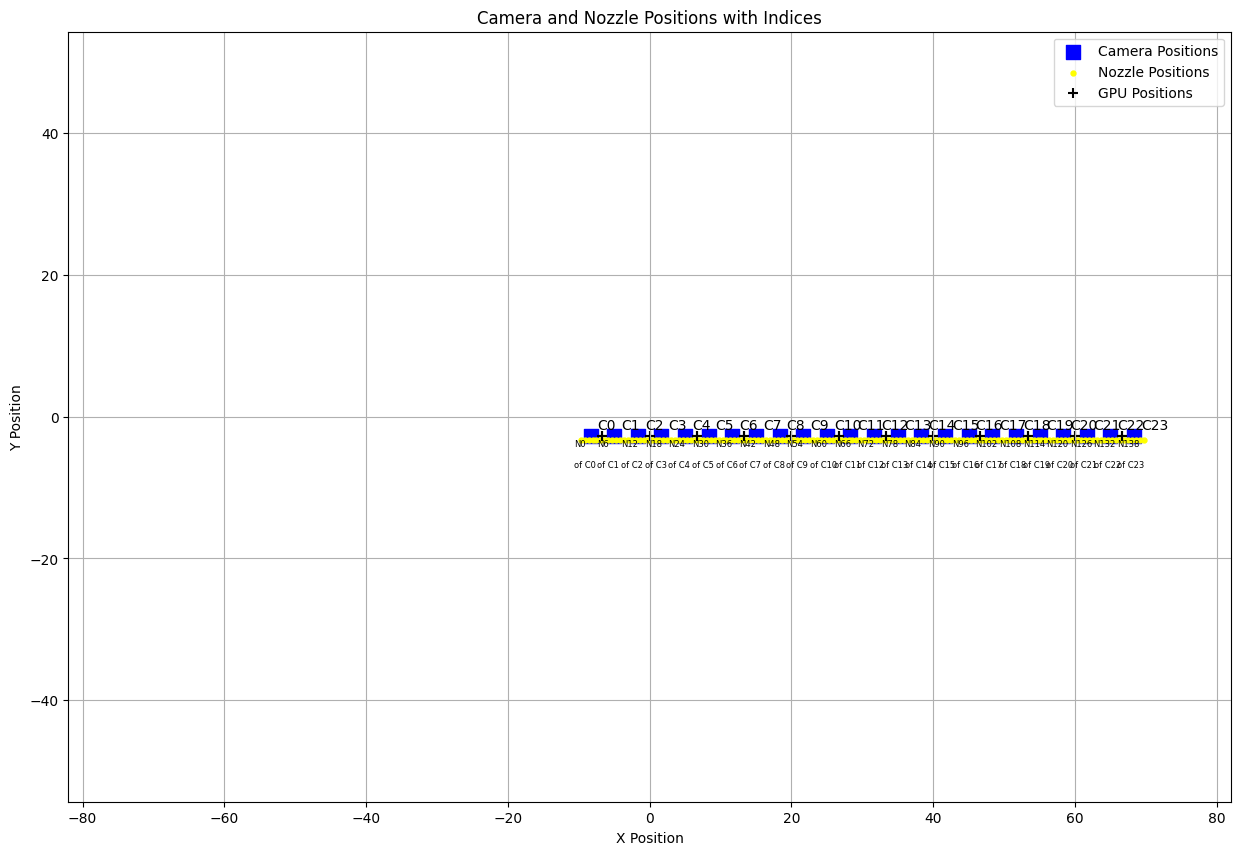

Number of cameras: 24
Number of nozzles: 144
Nozzles per camera: 6.0

First few camera positions:
Camera 0: (-8.333333333333336-2.7j)
Camera 1: (-5-2.7j)
Camera 2: (-1.6666666666666679-2.7j)
Camera 3: (1.6666666666666643-2.7j)
Camera 4: (5-2.7j)

First few nozzle positions:
Nozzle 0 of camera 0: (-9.722222222222221-3.25j)
Nozzle 1 of camera 0: (-9.166666666666671-3.25j)
Nozzle 2 of camera 0: (-8.611111111111114-3.25j)
Nozzle 3 of camera 0: (-8.055555555555557-3.25j)
Nozzle 4 of camera 0: (-7.5-3.25j)
gpu positoins 
GPU 0: (-6.666666666666668-2.7j)
GPU 1: (-6.666666666666668-2.7j)
GPU 2: (-1.7763568394002505e-15-2.7j)
GPU 3: (-1.7763568394002505e-15-2.7j)
GPU 4: (6.666666666666666-2.7j)
GPU 5: (6.666666666666666-2.7j)
GPU 6: (13.333333333333332-2.7j)
GPU 7: (13.333333333333332-2.7j)
GPU 8: (20-2.7j)
GPU 9: (20-2.7j)
GPU 10: (26.666666666666664-2.7j)
GPU 11: (26.666666666666664-2.7j)
GPU 12: (33.333333333333336-2.7j)
GPU 13: (33.333333333333336-2.7j)
GPU 14: (40-2.7j)
GPU 15: (40-2.7j)
G

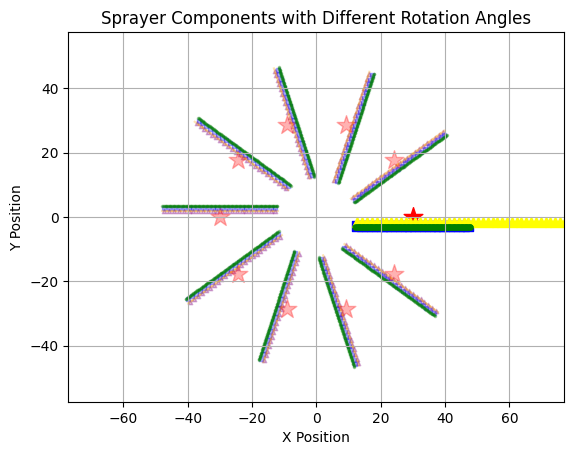

In [20]:
import matplotlib.pyplot as plt

# Plot discrete positions of sprayer, cameras and nozzles
plt.figure(figsize=(12, 8))

# Initialize sprayer
sprayer = Sprayer(40, 40, sprayer_origin=(30, 0))

# Get positions
sprayer_pos = sprayer.get_sprayer_position().value()
camera_positions = [(i,sprayer.get_camera_position(i).value()) for i in range(sprayer.number_of_cameras)]
nozzle_positions = [(i,sprayer.get_camera_index_of_nozzle(i),sprayer.get_nozzle_positions(i).value()) for i in range(sprayer.number_of_nozzles)]
gpu_position = [(i,sprayer.get_gpu_position_by_camera(i).value()) for i in range(sprayer.number_of_cameras)]
print(nozzle_positions[::6])
# Create the plot
plt.figure(figsize=(15, 10))

# Plot camera positions with indices
plt.scatter([pos[1].real for pos in camera_positions],
           [pos[1].imag for pos in camera_positions],
           color='blue', marker='s', s=100, label='Camera Positions')

# Add camera indices
for idx, pos in camera_positions:
    plt.annotate(f'C{idx}',
                (pos.real, pos.imag),
                xytext=(5, 5), textcoords='offset points')

# Plot nozzle positions with indices
plt.scatter([pos[2].real for pos in nozzle_positions],
           [pos[2].imag for pos in nozzle_positions],
           color='yellow', marker='.', s=50, label='Nozzle Positions')

# Plot nozzle positions with indices
plt.scatter([pos[1].real for pos in gpu_position],
           [pos[1].imag for pos in gpu_position],
           color='black', marker='+', s=50, label='GPU Positions')
print("gpu positions")
print(gpu_position)
print("camera positions")
print(camera_positions)
# Add nozzle indices (only every 6th nozzle to avoid overcrowding)
for idx,camera_index, pos in nozzle_positions[::6]:  # Show every 6th nozzle index
    plt.annotate(f'N{idx}',
                (pos.real, pos.imag),
                xytext=(-5, -5), textcoords='offset points',
                fontsize=6)
    plt.annotate(f'of C{camera_index}',
                (pos.real, pos.imag),
                xytext=(-5, -20), textcoords='offset points',
                fontsize=6)

# Add grid and labels
plt.grid(True)
plt.legend()
plt.axis('equal')

# Set axis limits with padding
max_val = max(
    max(abs(pos[1].real) for pos in camera_positions + nozzle_positions),
    max(abs(pos[1].imag) for pos in camera_positions + nozzle_positions)
)
padding = max_val * 0.2  # 20% padding
plt.xlim(-max_val - padding, max_val + padding)
plt.ylim(-max_val - padding, max_val + padding)

plt.title('Camera and Nozzle Positions with Indices')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

# Print some statistics
print(f"Number of cameras: {len(camera_positions)}")
print(f"Number of nozzles: {len(nozzle_positions)}")
print(f"Nozzles per camera: {len(nozzle_positions) / len(camera_positions):.1f}")

# Print first few positions for verification
print("\nFirst few camera positions:")
for idx, pos in camera_positions[:5]:
    print(f"Camera {idx}: {pos}")

print("\nFirst few nozzle positions:")
for idx, camera_index, pos in nozzle_positions[:5]:
    print(f"Nozzle {idx} of camera {camera_index}: {pos}")

print("gpu positoins ")
for idx, pos in gpu_position:
    print(f"GPU {idx}: {pos}")
sprayer = Sprayer(18, 18, sprayer_origin=(50, 0))
sprayer_pos = sprayer.get_sprayer_position().value()
camera_positions = [sprayer.get_camera_position(i).value() for i in range(sprayer.number_of_cameras)]

# Initialize sprayer
sprayer = Sprayer(18, 18, sprayer_origin=(30, 0))

# Get original positions
sprayer_pos = sprayer.get_sprayer_position().value()
camera_positions = [sprayer.get_camera_position(i).value() for i in range(sprayer.number_of_cameras)]
nozzle_positions = [sprayer.get_nozzle_positions(i).value() for i in range(sprayer.number_of_nozzles)]
camera__center_acquired_positions = [sprayer.get_camera_center_acquired_location(i).value() for i in range(sprayer.number_of_nozzles)]

# Plot original positions
plt.scatter([sprayer_pos.real], [sprayer_pos.imag],
           color='red', s=200, marker='*', label='Original Sprayer')
plt.scatter([p.real for p in camera_positions], [p.imag for p in camera_positions],
           color='blue', marker='s', s=50, label='Original Cameras')
plt.scatter([p.real for p in camera__center_acquired_positions], [p.imag for p in camera__center_acquired_positions],
           color='yellow', marker='^', s=50, label='Frame world positions')
plt.scatter([p.real for p in nozzle_positions], [p.imag for p in nozzle_positions],
           color='green', marker='.', s=50, label='Original Nozzles')

# Plot rotated positions for different k values
num_points=10
for k in range(1, num_points):
    angle = 2 * np.pi* k/num_points

    # Rotate positions
    rotated_sprayer = sprayer.get_sprayer_position().rotate(angle).value()
    rotated_cameras = [sprayer.get_camera_position(i).rotate(angle).value()
                      for i in range(sprayer.number_of_cameras)]


    rotated_nozzles = [sprayer.get_nozzle_positions(i).rotate(angle).value()
                      for i in range(sprayer.number_of_nozzles)]
    # Get and rotate acquisition positions
    rotated_acquisitions = [sprayer.get_camera_center_acquired_location(i).rotate(angle).value()
                          for i in range(sprayer.number_of_cameras)]
      # Get left and right points separately
    rotated_acquisitions_left = [pair[0].rotate(angle).value() for pair in [sprayer.get_camera_view_left_right(i) for i in range(sprayer.number_of_cameras)]]
    rotated_acquisitions_right = [pair[1].rotate(angle).value() for pair in [sprayer.get_camera_view_left_right(i) for i in range(sprayer.number_of_cameras)]]

    # Plot left points
    for left, right in zip(rotated_acquisitions_left, rotated_acquisitions_right):
        plt.plot([left.real, right.real],
                [left.imag, right.imag],
                color='orange', alpha=0.3,
                label='Acquisition lines' if (angle == 0) else "")  # Label only once

    plt.scatter([p.real for p in rotated_acquisitions], [p.imag for p in rotated_acquisitions],
               color='purple', marker='^', s=10, alpha=0.3, label=f'Acquisition points rotated by 2π/{k}')
    # Plot rotated positions with different colors and alpha for visibility
    plt.scatter([rotated_sprayer.real], [rotated_sprayer.imag],
               color='red', s=200, marker='*', alpha=0.3, label=f'Sprayer rotated by 2π/{k}')
    plt.scatter([p.real for p in rotated_cameras], [p.imag for p in rotated_cameras],
               color='blue', marker='s', s=10, alpha=0.3, label=f'Cameras rotated by 2π/{k}')
    plt.scatter([p.real for p in rotated_nozzles], [p.imag for p in rotated_nozzles],
               color='green', marker='.', s=10, alpha=0.3, label=f'Nozzles rotated by 2π/{k}')


# Add grid and labels
plt.grid(True)
# plt.legend()
plt.axis('equal')

# Set axis limits with padding
max_val = max(
    max(abs(p.real) for p in nozzle_positions + camera_positions + [sprayer_pos]),
    max(abs(p.imag) for p in nozzle_positions + camera_positions + [sprayer_pos])
)
padding = max_val * 0.2  # 20% padding
plt.xlim(-max_val - padding, max_val + padding)
plt.ylim(-max_val - padding, max_val + padding)

plt.title('Sprayer Components with Different Rotation Angles')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()



0
center camera pos (2.7048333333333296+6.02j)
i: 0
i_camera: 0
 i % nozzles_per_camera: 0.0
camera position: (0.5957083333333308+3.01j)
0
center camera pos (2.7048333333333296+6.02j)
R_turn: 18.0
c: -17.40429166666667
N_kx: -0.6305902777777739
N_ky: -0.28000000000000025
H: 3.01
R_gpu: 3.2998683065052417
0
center camera pos (2.7048333333333296+6.02j)
0
center camera pos (2.7048333333333296+6.02j)
0
center camera pos (2.7048333333333296+6.02j)
Radius: 18.0
Distance x: -0.8131117308992661
delta_x: -0.8131117308992701
delta_x_approx: -0.825704056312701
Distance y: -1.4148076224246333
delta_y: -1.134807622424633
delta_y_approx: -1.135925065521918
Total distance: 2.021374804020515
0
center camera pos (2.7048333333333296+6.02j)
i: 1
i_camera: 0
 i % nozzles_per_camera: 1.0
camera position: (0.5957083333333308+3.01j)
0
center camera pos (2.7048333333333296+6.02j)
R_turn: 18.0
c: -17.40429166666667
N_kx: -0.3783541666666643
N_ky: -0.28000000000000025
H: 3.01
R_gpu: 3.2998683065052417
0
center 

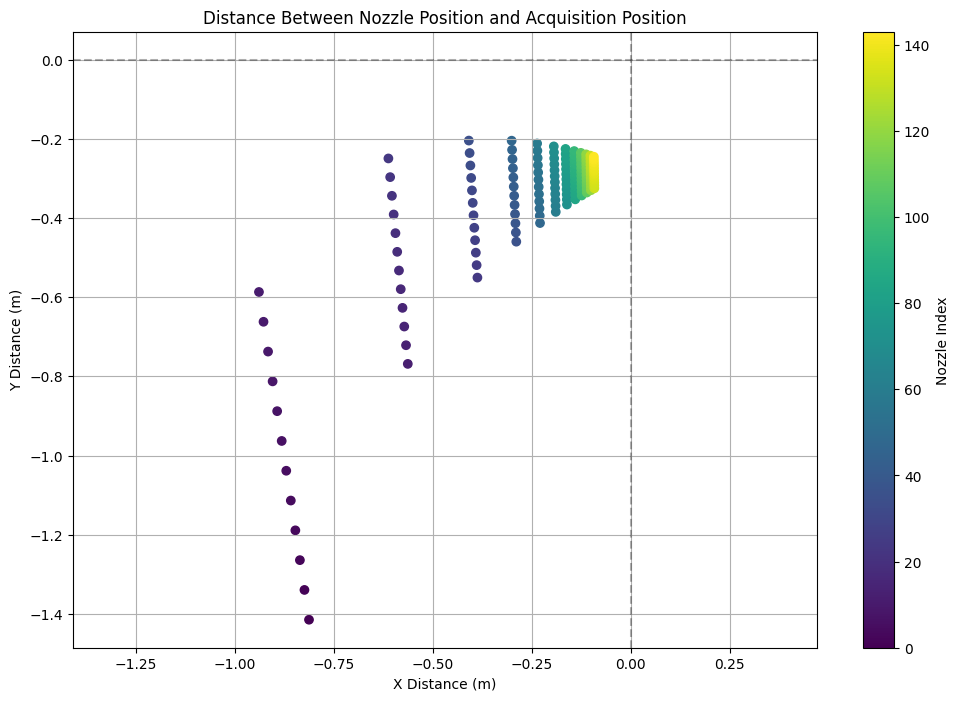

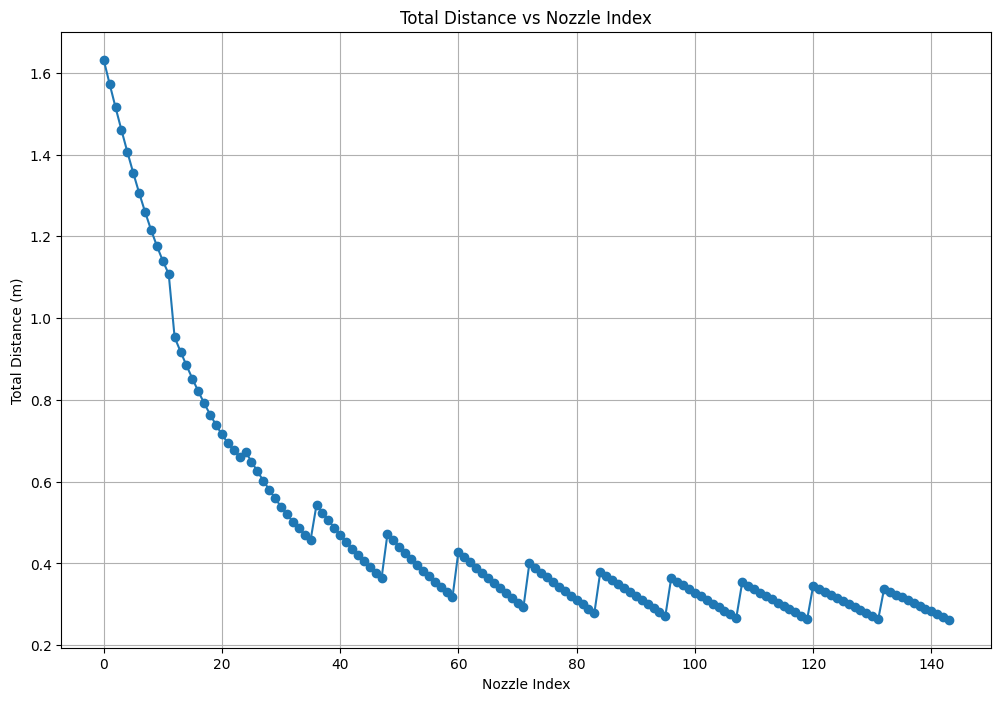

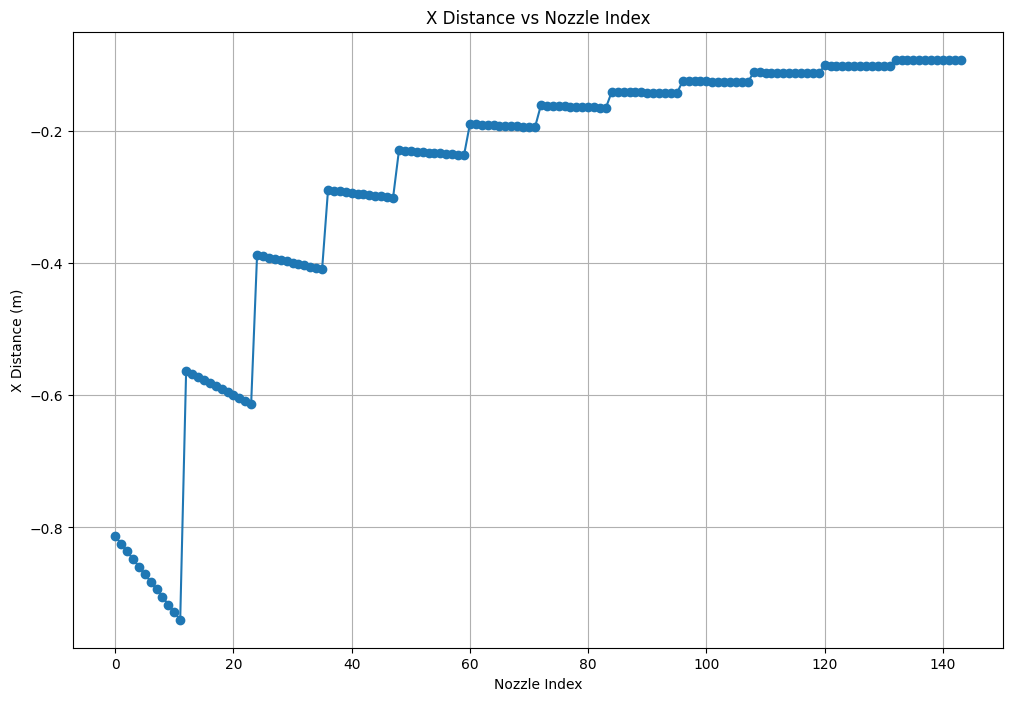

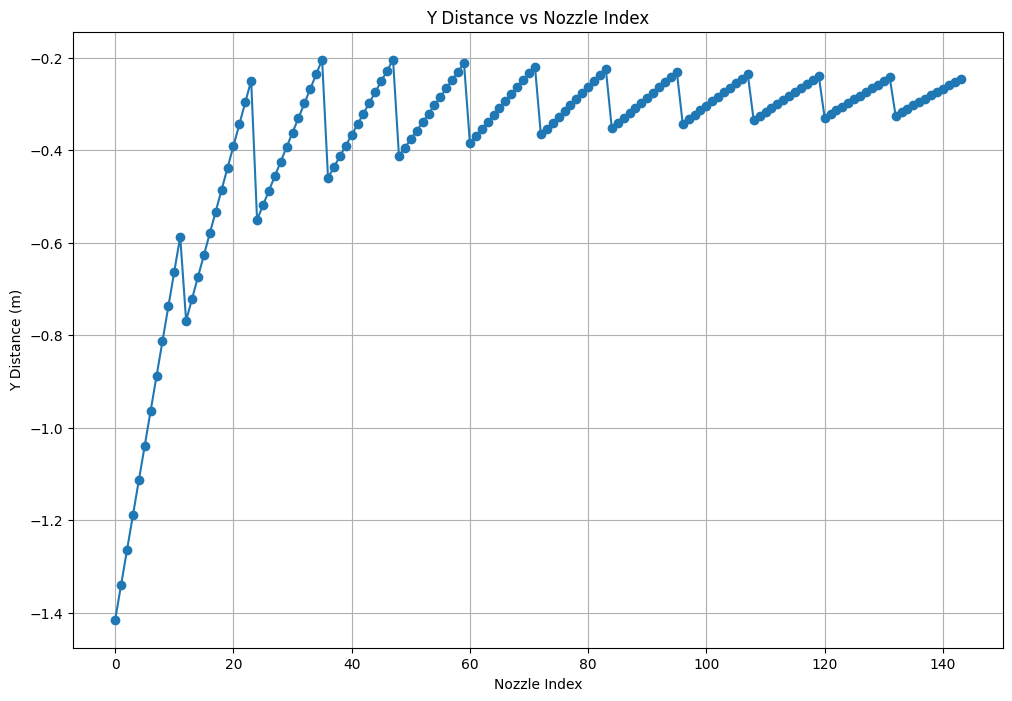

[-0.81311173 -0.82460538 -0.83609903 -0.84759268 -0.85908632 -0.87057997
 -0.88207362 -0.89356727 -0.90506092 -0.91655456 -0.92804821 -0.93954186
 -0.56353785 -0.56799095 -0.57244405 -0.57689715 -0.58135025 -0.58580335
 -0.59025645 -0.59470955 -0.59916265 -0.60361575 -0.60806885 -0.61252194
 -0.38762637 -0.38959716 -0.39156796 -0.39353875 -0.39550954 -0.39748033
 -0.39945113 -0.40142192 -0.40339271 -0.40536351 -0.4073343  -0.40930509
 -0.28939434 -0.29046324 -0.29153213 -0.29260103 -0.29366992 -0.29473882
 -0.29580771 -0.2968766  -0.2979455  -0.29901439 -0.30008329 -0.30115218
 -0.22948263 -0.23014533 -0.23080803 -0.23147074 -0.23213344 -0.23279614
 -0.23345885 -0.23412155 -0.23478426 -0.23544696 -0.23610966 -0.23677237
 -0.18967165 -0.19012055 -0.19056945 -0.19101835 -0.19146724 -0.19191614
 -0.19236504 -0.19281393 -0.19326283 -0.19371173 -0.19416063 -0.19460952
 -0.1614529  -0.16177635 -0.16209979 -0.16242324 -0.16274669 -0.16307014
 -0.16339359 -0.16371704 -0.16404049 -0.16436393 -0

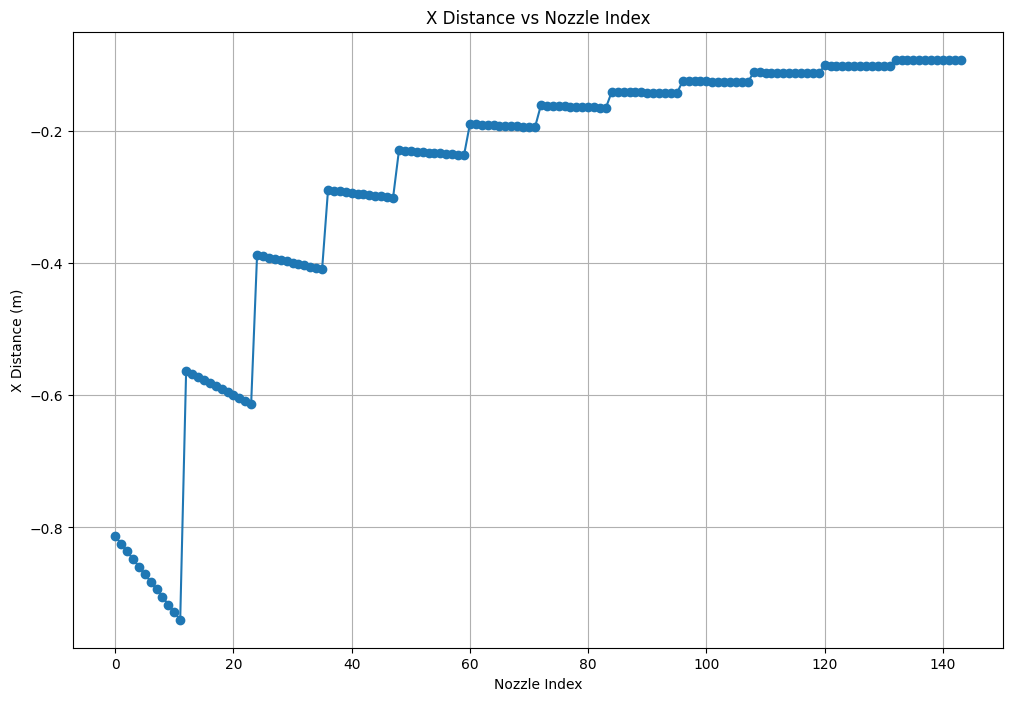

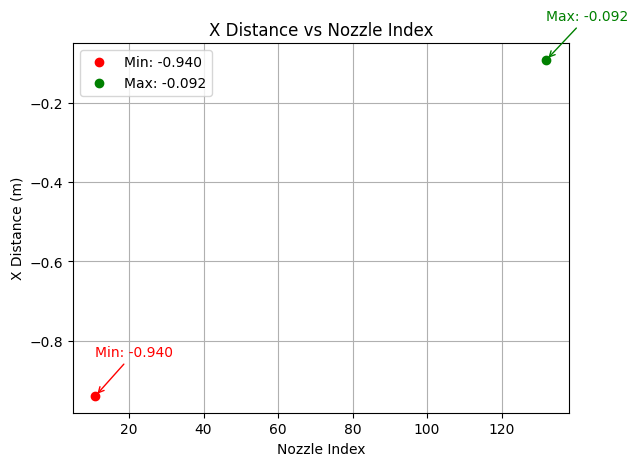

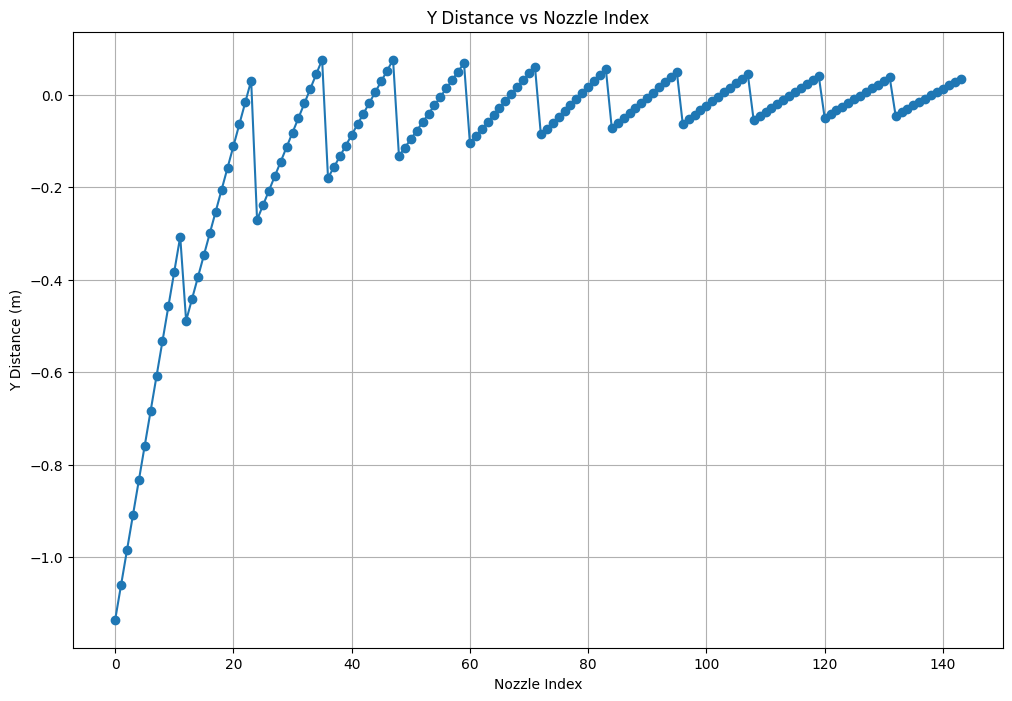

<Figure size 1200x800 with 0 Axes>

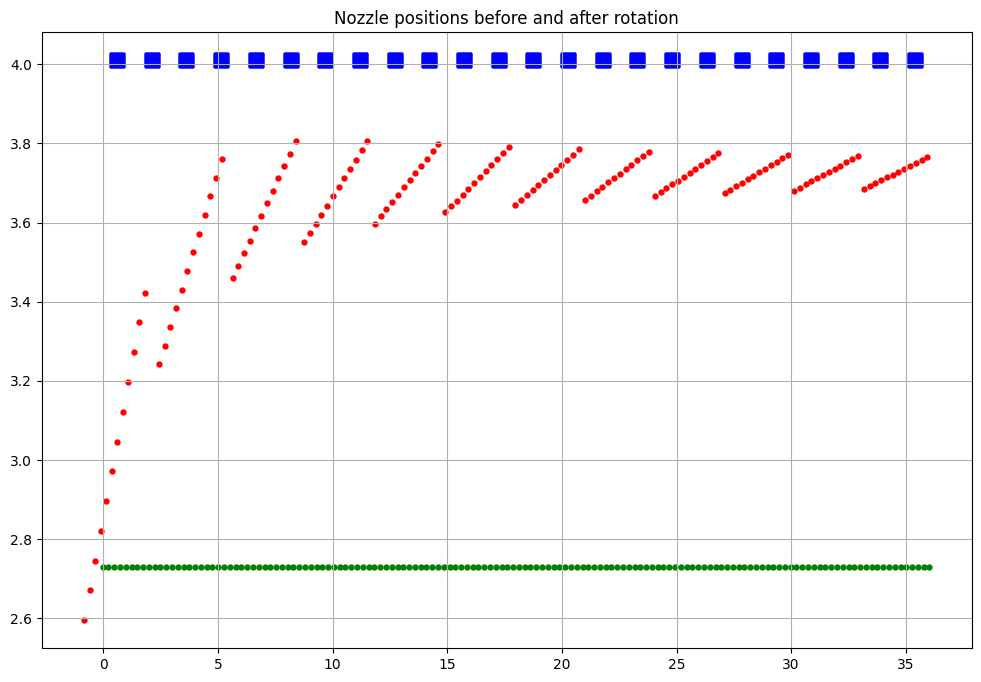

In [24]:
#sprayer=Sprayer(18,18,sprayer_origin=(30,0))

nozzles_per_camera = sprayer.number_of_nozzles / sprayer.number_of_cameras

def mm_to_meter(mm):
    return mm/1000

JD_big_sprayer =  {
     "R1":48,
     "boom_center": (0,mm_to_meter(4321)-mm_to_meter(6120.26)),
     "nozzle_offset_y_from_camera":0-mm_to_meter(261.67),
     "camera_offset_y":0,


     "boom_length":mm_to_meter(18161)
}

small_sprayer =  {
     "R1":18,
     "boom_center": (0,mm_to_meter(3010)),
     "nozzle_offset_y_from_camera":0-mm_to_meter(280),
     "camera_offset_y":0,

     "boom_length":mm_to_meter(18161)
}


sprayer = Sprayer.from_description(JD_big_sprayer)
sprayer = Sprayer.from_description(small_sprayer)
# sprayer=Sprayer(18,18,sprayer_origin=(R1,0),boom_center=(0,0),nozzle_offset_y=0,camera_offset_y=0,frame_distance=1)

def get_nozzle_index_per_camera(nozzles_per_camera, i):
    return i % nozzles_per_camera
distances = []
nozzle_before_rotation_positions = []
nozzle_after_rotation_positions = []
deltas_x = []
deltas_y = []
camera_positions = []
for i in range(sprayer.number_of_nozzles):
    i_camera=sprayer.get_camera_index_of_nozzle(i)
    # angle = 1/sprayer.get_camera_radius(i_camera)
    # rotate with gpu raduis and not with camera radius
    angle = 1/sprayer.get_gpu_radius(sprayer.get_gpu_index_by_camera(i_camera))
    nozzle_position=sprayer.get_nozzle_positions(i).rotate(angle).value()
    nozzle_before_rotation_positions.append(sprayer.get_nozzle_positions(i).value())
    nozzle_after_rotation_positions.append(nozzle_position)
    acquisition_center_position=sprayer.get_camera_center_acquired_location(i_camera).value()
    camera_positions.append(acquisition_center_position)
    left_right_position=sprayer.get_camera_view_left_right(i_camera)

    def get_nozzle_position_between_left_right(left, right, nozzle_index):
        # Get direction vector
        direction = right - left

        # Normalize the direction vector (make it unit length)
        # Using abs() for complex numbers gives the magnitude
        direction_normalized = direction / abs(direction)

        # Nozzle spacing vector in the right direction
        nozzle_spacing_vector = direction_normalized * sprayer.nozzle_spacing

        # Start half spacing from left
        return left + (nozzle_spacing_vector * 0.5) + (nozzle_spacing_vector * nozzle_index)

    nozzle_position_for_spraying_without_rotation=sprayer.get_nozzle_positions_for_spraying_without_rotation(i)
    distance=np.abs(nozzle_position-acquisition_center_position)
    acquisition_position = get_nozzle_position_between_left_right(left_right_position[0].value(),left_right_position[1].value(),get_nozzle_index_per_camera(nozzles_per_camera, i))
    distance_x=nozzle_position.real-acquisition_position.real
    distance_y=nozzle_position.imag-acquisition_position.imag



    print(f"i: {i}")
    print(f"i_camera: {i_camera}")
    print(f" i % nozzles_per_camera: {get_nozzle_index_per_camera(nozzles_per_camera, i)}")
    delta_x_approx
    print(f"camera position: {sprayer.get_camera_position(i_camera).value()}")
    # print(f"Acquisition center position: {acquisition_center_position}")
    # print(f"left_right_position: {left_right_position[0].value()}, {left_right_position[1].value()}")
    # print(f"length of left_right_position: {abs(left_right_position[1].value()-left_right_position[0].value())}")
    # print(f"right-left: {left_right_position[1].value()-left_right_position[0].value()}")
    # print(f"acquisition_position: {acquisition_position}")
    # print(f"nozzle_position_for_spraying_without_rotation: {nozzle_position_for_spraying_without_rotation.value()}")
    # print(f"nozzle_position_for_spraying_without_rotation == acquisition_position: {nozzle_position_for_spraying_without_rotation.value() == acquisition_position}")
    # print(f"nozzle_position before rotation: {sprayer.get_nozzle_positions(i).value()}")
    # print(f"Nozzle position after rotation: {nozzle_position}")


    # Parameters:
    # - R1: boom offset
    # - c: camera x-position
    # - b: relative nozzle offset from camera (can be positive or negative)
    # - H: camera height
    # - N: vertical offset from camera to nozzle
    # - nozzle_sign: +1 for right side, -1 for left side of the camera


    delta_x = delta_x_exact(R_turn=sprayer.get_sprayer_radius().real,
    c= sprayer.get_camera_relative_postion(i_camera).value().real,
    N_kx= sprayer.get_nozzle_positions(i).value().real-sprayer.get_camera_position(i_camera).value().real,
    N_ky= sprayer.get_nozzle_positions(i).value().imag- sprayer.get_camera_relative_postion(i_camera).value().imag,
    H = sprayer.get_camera_position(i_camera).value().imag,
    R_gpu=sprayer.get_gpu_position(sprayer.get_gpu_index_by_camera(i_camera)).get_radius())
    deltas_x.append(delta_x)
    delta_y = delta_y_exact(R_turn=sprayer.get_sprayer_radius().real,
    c= sprayer.get_camera_relative_postion(i_camera).value().real,
    N_kx= sprayer.get_nozzle_positions(i).value().real-sprayer.get_camera_position(i_camera).value().real,
    N_ky= sprayer.get_nozzle_positions(i).value().imag- sprayer.get_camera_relative_postion(i_camera).value().imag,
    H = sprayer.get_camera_position(i).value().imag,
    R_gpu=sprayer.get_gpu_position(sprayer.get_gpu_index_by_camera(i_camera)).get_radius())
    deltas_y.append(delta_y)
    delta_x_app = delta_x_approx(R_turn=sprayer.get_sprayer_radius().real,
    c= sprayer.get_camera_relative_postion(i_camera).value().real,
    N_kx= sprayer.get_nozzle_positions(i).value().real-sprayer.get_camera_position(i_camera).value().real,
    N_ky= sprayer.get_nozzle_positions(i).value().imag- sprayer.get_camera_relative_postion(i_camera).value().imag,
    H = sprayer.get_camera_position(i).value().imag,
    R_gpu=sprayer.get_gpu_position(sprayer.get_gpu_index_by_camera(i_camera)).get_radius())

    delta_y_app = delta_y_approx(R_turn=sprayer.get_sprayer_radius().real,
    c= sprayer.get_camera_relative_postion(i_camera).value().real,
    N_kx= sprayer.get_nozzle_positions(i).value().real-sprayer.get_camera_position(i_camera).value().real,
    N_ky= sprayer.get_nozzle_positions(i).value().imag- sprayer.get_camera_relative_postion(i_camera).value().imag,
    H = sprayer.get_camera_position(i).value().imag,
    R_gpu=sprayer.get_gpu_position(sprayer.get_gpu_index_by_camera(i_camera)).get_radius())


    distances.append((distance_x,distance_y,i,i_camera,get_nozzle_index_per_camera(nozzles_per_camera, i),delta_x,delta_y))
    print(f"Radius: {sprayer.get_sprayer_radius()}")
    # print(f"Camera Radius: {sprayer.get_camera_radius(i_camera)}")
    # print(f"Angle: {angle}")
    # print(f"1/2R: {1/(2*sprayer.get_camera_radius(i_camera))}")

    print(f"Distance x: {distance_x}")
    print(f"delta_x: {delta_x}")
    print(f"delta_x_approx: {delta_x_app}")

    print(f"Distance y: {distance_y}")
    print(f"delta_y: {delta_y}")
    print(f"delta_y_approx: {delta_y_app}")


    print(f"Total distance: {distance}")

# Convert distances list to numpy array for easier manipulation
distances_array = np.array(distances)

# Extract x and y distances
x_distances = distances_array[:,0]
y_distances = distances_array[:,1]

# Extract x and y distances
delta_x = distances_array[:,-2]
delta_y = distances_array[:,-1]
print('shape')
print(distances_array.shape)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(x_distances, y_distances, c=distances_array[:,2], cmap='viridis')
plt.colorbar(label='Nozzle Index')

plt.grid(True)
plt.title('Distance Between Nozzle Position and Acquisition Position')
plt.xlabel('X Distance (m)')
plt.ylabel('Y Distance (m)')

# Set equal aspect ratio so circles look circular
plt.axis('equal')

# Add zero lines
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.show()

# Plot distances vs nozzle index
plt.figure(figsize=(12, 8))
total_distances = np.sqrt(x_distances**2 + y_distances**2)
plt.plot(distances_array[:,2], total_distances, 'o-')
plt.grid(True)
plt.title('Total Distance vs Nozzle Index')
plt.xlabel('Nozzle Index')
plt.ylabel('Total Distance (m)')
plt.show()
# Plot x distances vs nozzle index
plt.figure(figsize=(12, 8))
plt.plot(distances_array[:,2], x_distances, 'o-')
plt.grid(True)
plt.title('X Distance vs Nozzle Index')
plt.xlabel('Nozzle Index')
plt.ylabel('X Distance (m)')
plt.show()

# Plot y distances vs nozzle index
plt.figure(figsize=(12, 8))
plt.plot(distances_array[:,2], y_distances, 'o-')
plt.grid(True)
plt.title('Y Distance vs Nozzle Index')
plt.xlabel('Nozzle Index')
plt.ylabel('Y Distance (m)')
plt.show()


print(delta_x)
print(delta_x.shape)
plt.figure(figsize=(12, 8))
plt.plot(distances_array[:,2], delta_x, 'o-')
plt.grid(True)
plt.title('X Distance vs Nozzle Index')
plt.xlabel('Nozzle Index')
plt.ylabel('X Distance (m)')
plt.show()



# Assuming distances_array is already defined
delta_x = distances_array[:, -2]  # or distances_array[:, 0]
nozzle_index = distances_array[:, 2]  # x-axis data

# Get min and max values and their indices
min_val = np.min(delta_x)
max_val = np.max(delta_x)
min_idx = np.argmin(delta_x)
max_idx = np.argmax(delta_x)

# Get corresponding nozzle indices for min and max
min_nozzle = nozzle_index[min_idx]
max_nozzle = nozzle_index[max_idx]

# # Plot
# plt.figure(figsize=(12, 8))
# plt.plot(nozzle_index, delta_x, 'o-', label='X Distance')

# Add min and max points
plt.plot(min_nozzle, min_val, 'ro', label=f'Min: {min_val:.3f}')
plt.plot(max_nozzle, max_val, 'go', label=f'Max: {max_val:.3f}')

# Annotate values
plt.annotate(f'Min: {min_val:.3f}', xy=(min_nozzle, min_val), xytext=(min_nozzle, min_val + 0.1),
             arrowprops=dict(arrowstyle='->', color='red'), color='red')
plt.annotate(f'Max: {max_val:.3f}', xy=(max_nozzle, max_val), xytext=(max_nozzle, max_val + 0.1),
             arrowprops=dict(arrowstyle='->', color='green'), color='green')

plt.grid(True)
plt.title('X Distance vs Nozzle Index')
plt.xlabel('Nozzle Index')
plt.ylabel('X Distance (m)')
plt.legend()
plt.show()


# Plot y distances vs nozzle index
plt.figure(figsize=(12, 8))
plt.plot(distances_array[:,2], delta_y, 'o-')
plt.grid(True)
plt.title('Y Distance vs Nozzle Index')
plt.xlabel('Nozzle Index')
plt.ylabel('Y Distance (m)')
plt.show()



plt.figure(figsize=(12, 8))


plt.figure(figsize=(12, 8))
plt.grid(True)
plt.title('Nozzle positions before and after rotation')

plt.scatter([p.real for p in nozzle_after_rotation_positions], [p.imag for p in nozzle_after_rotation_positions],
           color='red', marker='.', s=50, label='Nozzles after rotation')
plt.scatter([p.real for p in nozzle_before_rotation_positions], [p.imag for p in nozzle_before_rotation_positions],
           color='green', marker='.', s=50, label='Nozzles before rotation')
plt.scatter([p.real for p in camera_positions], [p.imag for p in camera_positions],
           color='blue', marker='s', s=100, label='Cameras')

In [21]:
small_sprayer =  {
     "R1":48,
     "boom_center": (0,mm_to_meter(3010)),
     "nozzle_offset_y_from_camera":0-mm_to_meter(280),
     "camera_offset_y":0,

     "boom_length":mm_to_meter(18161)
}

sprayer = Sprayer.from_description(small_sprayer)
for i in range(sprayer.number_of_nozzles):
    i_camera=sprayer.get_camera_index_of_nozzle(i)
    # angle = 1/sprayer.get_camera_radius(i_camera)
    # rotate with gpu raduis and not with camera radius
    angle = 1/sprayer.get_gpu_radius(sprayer.get_gpu_index_by_camera(i_camera))


0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
0
center camera pos (62.704833333333326+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
1
center camera pos (68.7585+6.02j)
2
ce

#Speed Variation Mathematical Explanation

## Basic Speed Equations

When a sprayer turns, the speed at different points along the boom varies due to the circular motion. The following equations describe these relationships:

### Center Speed
The speed at the center of the sprayer (GPS position) is given by:
$$V_{\mathrm{center}} = \omega R$$

where:
- $\omega$ is the angular velocity (rad/s)
- $R$ is the turn radius (m)

### Inner Boom Speed
The speed at the inner boom (left side) is:
$$V_{\mathrm{inner}} = \omega(R - \ell_{\mathrm{left}})$$

where:
- $\ell_{\mathrm{left}}$ is the length of the left boom (m)

### Outer Boom Speed
The speed at the outer boom (right side) is:
$$V_{\mathrm{outer}} = \omega(R + \ell_{\mathrm{right}})$$

where:
- $\ell_{\mathrm{right}}$ is the length of the right boom (m)

## Speed Ratio and Variation

### Speed Ratio (α)
The ratio between outer and center speed is:
$$\alpha = \frac{V_{\mathrm{outer}}}{V_{\mathrm{center}}} = \frac{R + \ell_{\mathrm{right}}}{R}$$

### Speed Variation
The percentage variation in speed is calculated as:
$$\mathrm{Variation} = \frac{V_{\mathrm{outer}} - V_{\mathrm{center}}}{V_{\mathrm{center}}} \times 100\% = (\alpha - 1) \times 100\%$$

## Finding Turn Radius

To achieve a specific speed variation, we can solve for the required turn radius:
$$R = \frac{\ell_{\mathrm{right}}}{\alpha - 1}$$

where:
- $\alpha = 1 + \frac{\mathrm{variation}}{100}$

## Key Points

1. **Speed Ratio (α)**
   - Must always be > 1 because:
     - Outer boom travels further in same time
     - Must move faster to cover larger distance
     - Cannot be slower than center speed

2. **Practical Limits**
   - Code uses variations from 5% to 50%
   - This means α ranges from 1.05 to 1.50
   - These are realistic values for sprayer operation

3. **Relationships**
   - $\alpha = 1 + \frac{\mathrm{variation}}{100}$
   - $\mathrm{variation} = (\alpha - 1) \times 100$

## Example Calculations

### For 20% Variation
- $\alpha = 1 + \frac{20}{100} = 1.20$
- If $\ell_{\mathrm{right}} = 18$m:
  - $R = \frac{18}{1.20 - 1} = 90$m

### For 50% Variation
- $\alpha = 1 + \frac{50}{100} = 1.50$
- If $\ell_{\mathrm{right}} = 18$m:
  - $R = \frac{18}{1.50 - 1} = 36$m

## Implementation Notes

The code implements these relationships in the following functions:

1. `calculate_speed_variation`: Calculates the speed variation between center and boom ends
2. `find_radius_for_variation`: Determines the turn radius needed for a target variation
3. `calculate_speed_at_position`: Computes speed at any position along the boom

The visualization shows:
- Inner radius circles (left subplot)
- Outer radius circles (right subplot)
- Color-coded variations from 5% to 50%
- Annotations showing radius and variation at each point